# Getting Started with Spanky's

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import simpy
import itertools
import random
import pandas as pd
import numpy as np

## Menu

In [6]:
menu = {
    'pizza': {'probability': 0.4, 'prep time': 0, 'cook time': 13},
    'sticks': {'probability': 0.3, 'prep time': 1, 'cook time': 10},
    'nuggets': {'probability': 0.2, 'prep time': 1, 'cook time': 10},
    'rolls': {'probability': 0.1, 'prep time': 0, 'cook time': 8}
}
menu = pd.DataFrame(menu)

items = menu.columns
probs = menu.ix['probability',:]

menu

,nuggets,pizza,rolls,sticks
cook time,10.0,13.0,8.0,10.0
prep time,1.0,0.0,0.0,1.0
probability,0.2,0.4,0.1,0.3


## Model

In [103]:
class Spanky(object):

    def __init__(self,N_SERVERS=1,N_OVENS=2,T_ORDER=10):
        self.env = simpy.Environment()
        self.server = simpy.Resource(self.env,N_SERVERS)   # server resources
        self.oven = simpy.Resource(self.env,N_OVENS)       # oven resources
        self.T_ORDER = T_ORDER
        self.data = dict()
        self.orderQueue = pd.Series([0],[0])               # track orders in progress
        self.env.process(self.orderGenerator())            # where to start the model
        
    def writeLog(self,orderId,item,event,t=None):
        if t==None:
            t = self.env.now
        self.data[orderId,item,event] = t
        
    @property
    def log(self):
        df = pd.DataFrame([[a,b,c,self.data[a,b,c]] for (a,b,c) in self.data.keys()])
        df.columns = ['OrderID','Item','Event','Time']
        return df.pivot_table(values='Time',index=['OrderID','Item'],columns=['Event'])
    
    def stats(self):
        df = w.log
        late = df['5 finish']-df['6 tquote']
        late = late[late > 0]
        
        N_orders = df[df['1 order']>0]['1 order'].count()
        N_finished = df[df['5 finish']>0]['5 finish'].count()
        N_late = late.count()
        N_latefrac = N_late/N_orders
        N_meanlate = late.mean()
        N_maxlate = late.max()
        
        print("       Orders Received = {0:6d}".format(N_orders))
        print("       Orders Finished = {0:6d}".format(N_finished))
        print("           Late Orders = {0:6d}".format(N_late))
        print("Fraction that are late = {0:6.3f}".format(N_latefrac))
        print("      Average lateness = {0:6.3f}".format(N_meanlate))
        print("      Maximum lateness = {0:6.3f}".format(N_maxlate))
        
        plt.subplot(2,1,1)
        late.hist()
        plt.title('Distribution of Late Orders')
        plt.ylabel('Number of orders')
        plt.xlabel('Minutes late')
        plt.subplot(2,1,2)
        w.orderQueue.plot()
        plt.xlabel('Time [min]')
        plt.ylabel('Orders')
        plt.title('Orders in Process')
        plt.tight_layout()

    def writeOrderQueue(self,inc):                         # track orders in progress
        self.orderQueue[self.env.now] = self.orderQueue.iloc[-1] + inc
        
    def order(self,orderId,item):
        # take order from customer
        with self.server.request() as serverreq:
            yield serverreq
            self.writeLog(orderId,item,'1 order')
            self.writeOrderQueue(+1)
            yield self.env.timeout(0.5)
            # give receipt to customer
            self.writeLog(orderId,item,'2 receipt')
            # quote finish time to customer
            tquote = self.env.now + menu[item]['prep time'] + menu[item]['cook time'] + 0.5
            self.writeLog(orderId,item,'6 tquote',tquote)
            
        # request server to prep order
        with self.server.request() as serverreq:
            yield serverreq
            self.writeLog(orderId,item,'3 prep')
            yield self.env.timeout(menu[item]['prep time'])
        
        # request oven to cook order
        with self.oven.request() as ovenreq:
            yield ovenreq
            # request server to load oven
            with self.server.request() as serverreq:
                yield serverreq
                yield self.env.timeout(0.25)
                self.writeLog(orderId,item,'4 oven') 
            # cook order
            yield self.env.timeout(menu[item]['cook time'])
            # request server to unload oven
            with self.server.request() as serverreq:
                yield serverreq
                yield self.env.timeout(0.25)
                self.writeLog(orderId,item,'5 finish')
                self.writeOrderQueue(-1)
            
    def orderGenerator(self):
        for orderId in itertools.count():
            yield self.env.timeout(random.expovariate(1.0/self.T_ORDER))
            item = np.random.choice(items,p = probs)
            self.writeLog(orderId,item,'0 arrival')
            self.env.process(self.order(orderId,item))

    def run(self,t_sim):
        self.env.run(until=t_sim)

       Orders Received =     17
       Orders Finished =     13
           Late Orders =      5
Fraction that are late =  0.294
      Average lateness =  2.664
      Maximum lateness =  6.152


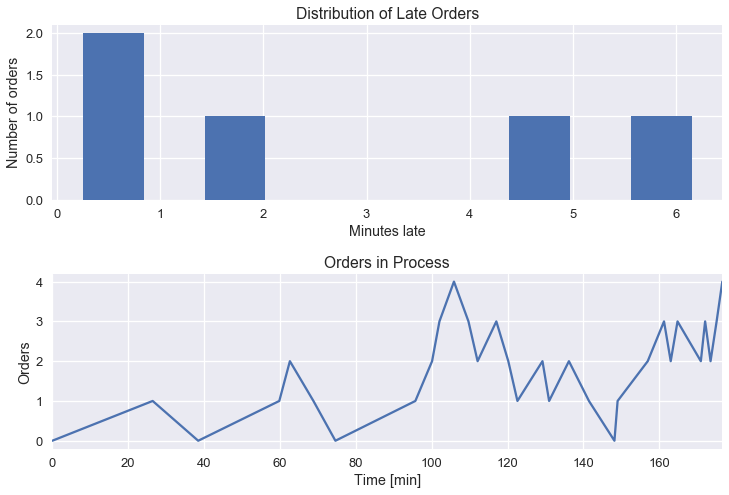

In [104]:
# create Spanky's with one server, two ovens, with orders arriving at an average of 10 minutes
w = Spanky(1,2,10)

# run a simulation for 180 minutes
w.run(180)

# summarize data
w.stats()

In [120]:
df = w.log
s = df['0 arrival'].copy()
for c in df.columns:
    print(c)
    df[c] = df[c] - s

df.groupby(level=1).mean()

0 arrival
1 order
2 receipt
3 prep
4 oven
5 finish
6 tquote


Event,0 arrival,1 order,2 receipt,3 prep,4 oven,5 finish,6 tquote
Item,,,,,,,
nuggets,0.0,0.000000,0.500000,0.500000,3.889440,14.139440,12.000000
pizza,0.0,0.037232,0.537232,0.537232,0.982967,14.000000,14.037232
rolls,0.0,0.000000,0.500000,0.500000,0.750000,9.000000,9.000000
sticks,0.0,0.000000,0.500000,0.500000,3.362145,13.149871,12.000000
